In [1]:
import numpy as np
import matplotlib.pyplot as plt


## Loading data

In [2]:
from coco_utils import load_coco_data, load_coco_data_struct, sample_coco_minibatch, decode_captions
from image_utils import image_from_url


In [3]:
vocab_data, train_data, _  = load_coco_data_struct() # igore actual coco val set
val_data, train_data = train_data.split(0.3) # split further into train/val


Loaded vocab data.
Embedding <class 'numpy.ndarray'> (1004, 304) float64
Word to index <class 'dict'> 1004
Index to word <class 'list'> 1004

Loaded train data.
Captions <class 'numpy.ndarray'> (400135, 17) int32
Image indices <class 'numpy.ndarray'> (400135,) int32
Image features <class 'numpy.ndarray'> (82783, 4096) float32
Image urls <class 'numpy.ndarray'> (82783,) <U63

Loaded val data.
Captions <class 'numpy.ndarray'> (195954, 17) int32
Image indices <class 'numpy.ndarray'> (195954,) int32
Image features <class 'numpy.ndarray'> (40504, 4096) float32
Image urls <class 'numpy.ndarray'> (40504,) <U63

Splitting train data with ratio 0.3

Loaded train data.
Captions <class 'numpy.ndarray'> (120040, 17) int32
Image indices <class 'numpy.ndarray'> (120040,) int32
Image features <class 'numpy.ndarray'> (82783, 4096) float32
Image urls <class 'numpy.ndarray'> (82783,) <U63

Loaded train data.
Captions <class 'numpy.ndarray'> (280095, 17) int32
Image indices <class 'numpy.ndarray'> (2800

In [4]:
def sample_image(coco_data, batch_size):
    captions, features, urls = coco_data.sample(batch_size)
    show_image_caption(captions, features, urls)

def show_image_by_data_idx(coco_data, data_idx):
    captions, features, urls = coco_data.get(data_idx)
    show_image_caption(captions, features, urls)

def show_image_caption(captions, features, urls):
    for i, (caption, url) in enumerate(zip(captions, urls)):
        plt.imshow(image_from_url(url))
        plt.axis('off')
        caption_str = vocab_data.decode_captions(caption)
        plt.title(caption_str)
        plt.show()

def show_image_by_image_idxs(coco_data, img_idxs):
    """
        data indices to find image
    """
    urls = coco_data.get_urls_by_image_index(img_idxs)
    for url in urls:
        plt.imshow(image_from_url(url))
        plt.axis('off')
        plt.show()

In [5]:
def group_data_idx_by_image_idx(image_ids_in_caption_data_order):
    """
        Group image index, which is the same index position as corresponding caption data, by image id.
        i.e {8731 : [0,60,99,305]} caption and image features at these 4 positions correspond to image id 8731
    """
    image_positions_by_image_id = {}
    for i, img_id in enumerate(image_ids_in_caption_data_order):
        if img_id in image_positions_by_image_id:
            image_positions_by_image_id[img_id].append(i)
        else:
            image_positions_by_image_id[img_id] = [i]
    return image_positions_by_image_id

def map_grouped_data_index_to_grouped_captions(caption_data, grouped_image_index):
    """
        For each image id "key", get its corresponding captions, retrieved by "value" of the image instance indices.
        Image instance indices is assumed to be in the same order as the caption data.
    """
    captions_by_image_id = {}
    for k, v in grouped_image_index.items():
        captions_by_image_id[k] = caption_data[v]
    return captions_by_image_id

def scramble_image_caption_pairs(caption_data, grouped_image_index):    
    to_shuffle_caption = np.copy(caption_data)
    np.random.shuffle(to_shuffle_caption)
    return map_grouped_data_index_to_grouped_captions(to_shuffle_caption, grouped_image_index)

def flatten_image_caption_groups(grouped_captions):
    all_captions = []
    all_image_ids = []
    for k, v in grouped_captions.items():
        all_image_ids += [k] * len(v) # duplicate lables
        all_captions.append(v)
    flat_image_ids = np.array(all_image_ids)
    flat_captions = np.concatenate(all_captions, axis=0)
    assert flat_image_ids.shape[0] == flat_captions.shape[0]
    return flat_image_ids, flat_captions

def merge_demo_sampled(demo_image, demo_caption, sampled_image, sampled_caption):
    is_demo = np.ones(demo_image.shape)
    is_sample = np.ones(sampled_image.shape) * -1
    return np.concatenate([demo_image, sampled_image], axis=0), np.concatenate([demo_caption, sampled_caption], axis=0), np.concatenate([is_demo, is_sample], axis=0)



In [6]:
# minibatch
class MiniBatcher(object):
    def __init__(self, batchable_tuple):
        shapes = [b.shape[0] for b in batchable_tuple]
        assert all([s == shapes[0] for s in shapes]), "Data to be batched together should have the same first dimension"
        self.batchable_tuple = batchable_tuple
        self.data_size = shapes[0]
    
    def sample(self, batch_size=100):
        assert batch_size <= self.data_size
        mask = np.random.choice(self.data_size, batch_size)
        batch_list = [b[mask] for b in self.batchable_tuple]
        return tuple(batch_list)
    
def create_demo_sampled_batcher(coco_data):
    # create random pairing
    grouped_data_index_by_image_idx = group_data_idx_by_image_idx(coco_data.image_idx)
    grouped_captions_by_image_idx = map_grouped_data_index_to_grouped_captions(coco_data.captions_in_word_idx, grouped_data_index_by_image_idx)
    scrambled_grouped_captions_by_image_idx = scramble_image_caption_pairs(coco_data.captions_in_word_idx, grouped_data_index_by_image_idx)

    # merge both, and retain flag
    image_idx_demo, captions_demo = flatten_image_caption_groups(grouped_captions_by_image_idx)
    image_idx_sampled, caption_sampled = flatten_image_caption_groups(scrambled_grouped_captions_by_image_idx)

    demo_batcher = MiniBatcher((image_idx_demo, captions_demo, np.ones(image_idx_demo.shape)))
    sample_batcher = MiniBatcher((image_idx_sampled, caption_sampled, np.zeros(image_idx_sampled.shape)))
    return demo_batcher, sample_batcher

def process_mini_batch(batcher1, batcher2, batch_size):
    image_idx_batch1, caption_batch1, demo_or_sampled_batch1 = batcher1.sample(batch_size)
    image_idx_batch2, caption_batch2, demo_or_sampled_batch2 = batcher2.sample(batch_size)
    image_idx_batch = np.concatenate([image_idx_batch1, image_idx_batch2], axis=0)
    caption_batch = np.concatenate([caption_batch1, caption_batch2], axis=0)    
    demo_or_sampled_batch = np.concatenate([demo_or_sampled_batch1, demo_or_sampled_batch2], axis=0)   
    return image_idx_batch, caption_batch, demo_or_sampled_batch


In [7]:
demo_batcher, sample_batcher = create_demo_sampled_batcher(train_data)
val_demo_batcher, val_sample_batcher = create_demo_sampled_batcher(val_data)

In [29]:
def examine_validation(batch_size=100, to_examine=True):
    image_idx_batch, caption_batch, demo_or_sampled_batch = process_mini_batch(val_demo_batcher, val_sample_batcher, batch_size)
    caption_batch = caption_batch[:,1:]
    loss, reward_per_token, mean_reward = run_validation(sess, discr, val_data, image_idx_batch, caption_batch, demo_or_sampled_batch)
    if to_examine:
        examine(val_data, image_idx_batch, caption_batch, reward_per_token, mean_reward)
    return loss

def assign_reward(sess, discr, coco_data, img_idxs, caption_sentences):
    captions = [c.split() for c in caption_sentences]
    image_feats_test = coco_data.get_image_features(img_idxs)
    caption_test = vocab_data.encode_captions(captions)
    loss, reward_per_token, mean_reward = run_test(sess, discr, image_feats_test, caption_test)
    examine(coco_data, img_idxs, caption_test, reward_per_token, mean_reward)
    return loss, reward_per_token, mean_reward

def run_validation(sess, discr, coco_data, img_idxs, caption_word_idx, demo_or_sampled_batch):
    image_feats = coco_data.get_image_features(img_idxs)
    discr.image_input.pre_feed(image_feats)
    discr.caption_input.pre_feed(caption_word_idx)
    discr.metadata_input.pre_feed(labels=demo_or_sampled_batch)
    loss, reward_per_token, mean_reward = discr.test(sess)
    return loss, reward_per_token, mean_reward
    
def run_test(sess, discr, img_feature_test, caption_test):
    discr.image_input.pre_feed(img_feature_test)
    discr.caption_input.pre_feed(caption_test)
    discr.metadata_input.pre_feed(labels=np.ones(img_feature_test.shape[0]))
    loss, reward_per_token, mean_reward = discr.test(sess)
    return loss, reward_per_token, mean_reward
                           
def examine(coco_data, chosen_img, chosen_caption, chosen_reward_per_token, chosen_mean_reward):
    for (img_idx, cap, r, me_r) in zip(chosen_img, chosen_caption, chosen_reward_per_token, chosen_mean_reward):
        print("Avg reward: ", me_r)
        show_image_by_image_idxs(coco_data, [img_idx])
        decoded = vocab_data.decode_captions(cap).split()
        for (i,j) in zip(decoded, r):
            print("{:<15} {}".format(i, j))

        print("- - - -")
    
def examine_batch_results(coco_data, demo_or_sample, image_id, caption_batch, reward_per_token, mean_reward):
    num_to_examine = 4

    def examine_sample(chosen):
        print(chosen)
        chosen_img = image_id[chosen]
        chosen_cap = caption_batch[chosen]
        chosen_reward_per_token = reward_per_token[chosen]
        chosen_mean_reward = mean_reward[chosen]
        
        examine(coco_data, chosen_img, chosen_cap, chosen_reward_per_token, chosen_mean_reward)
    
    print("DEMO RESULTS")    
    chosen = np.random.choice(np.where( demo_or_sampled_batch == 1 )[0], num_to_examine)
    examine_sample(chosen)
    print("\n\nSAMPLED RESULTS")
    chosen = np.random.choice(np.where( demo_or_sampled_batch == 0 )[0], num_to_examine)
    examine_sample(chosen)

def random_sentence():
    word_idxs = np.random.choice(np.arange(vocab_data.START_ID + 1, vocab_data.vocab_dim), np.random.randint(8,12))
    return vocab_data.decode_captions(np.array([word_idxs]))


## Model

In [9]:
import tensorflow as tf
from discriminator import CaptionInput, ImageInput, MetadataInput, Discriminator

In [10]:
tf.reset_default_graph()
caption_input = CaptionInput(word_embedding_init=vocab_data.embedding(),null_id=vocab_data.NULL_ID)
image_input = ImageInput(image_feature_dim=train_data.image_feature_dim)
metadata_input = MetadataInput()
discr = Discriminator(caption_input, image_input, metadata_input, hidden_dim=512)

## Training

In [11]:
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

In [24]:
iter_num = 400
batch_size = 1000

train_losses = []
val_losses = []
for i in range(iter_num):
    
    image_idx_batch, caption_batch, demo_or_sampled_batch = process_mini_batch(
        demo_batcher, 
        sample_batcher,
        batch_size
    )
    caption_batch = caption_batch[:,1::]
    image_feats_batch = train_data.get_image_features(image_idx_batch)
    
    discr.caption_input.pre_feed(caption_word_ids=caption_batch)
    discr.image_input.pre_feed(image_features=image_feats_batch)
    discr.metadata_input.pre_feed(demo_or_sampled_batch)
    loss, m, me = discr.train(sess)
        
    train_losses.append(loss)
    if i % 20 ==0:
        print("iter {}, loss: {}".format(i, loss))
    
    if i % 5 ==0:
        val_loss = examine_validation(batch_size, to_examine=False)
        val_losses.append(val_loss)
    else:
        val_losses.append(val_losses[-1])
        


iter 0, loss: -9.92519760131836
iter 20, loss: -9.224407196044922
iter 40, loss: -10.035253524780273
iter 60, loss: -11.616401672363281
iter 80, loss: -12.611595153808594
iter 100, loss: -12.622101783752441
iter 120, loss: -13.667672157287598
iter 140, loss: -14.042041778564453
iter 160, loss: -14.748800277709961
iter 180, loss: -15.52587604522705
iter 200, loss: -17.017053604125977
iter 220, loss: -17.533231735229492
iter 240, loss: -17.78657341003418
iter 260, loss: -18.243661880493164
iter 280, loss: -19.027254104614258
iter 300, loss: -21.294755935668945
iter 320, loss: -20.704713821411133
iter 340, loss: -22.234344482421875
iter 360, loss: -22.234600067138672
iter 380, loss: -23.904735565185547


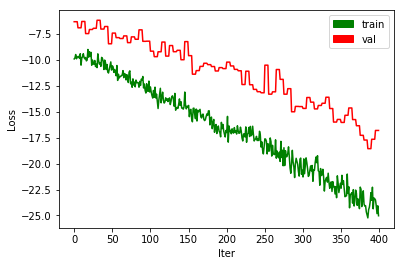

In [25]:
import matplotlib.patches as mpatches

plt.plot(np.arange(0, len(train_losses)), train_losses, 'g', val_losses, 'r')
train_loss_patch = mpatches.Patch(color='g', label='train')
val_loss_patch = mpatches.Patch(color='r', label='val')
plt.legend(handles=[train_loss_patch, val_loss_patch])
plt.ylabel('Loss')
plt.xlabel('Iter')
plt.show()

DEMO RESULTS
[494 738 643 295]
Avg reward:  45.0856


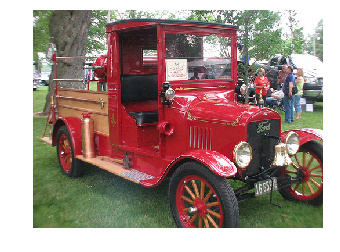

antique         24.156883239746094
fire            14.987733840942383
truck           35.794883728027344
<UNK>           77.3260726928711
and             82.9838638305664
displayed       68.94976806640625
at              60.95476150512695
outdoor         23.222562789916992
event           -30.893030166625977
<END>           93.3725357055664
- - - -
Avg reward:  41.0723


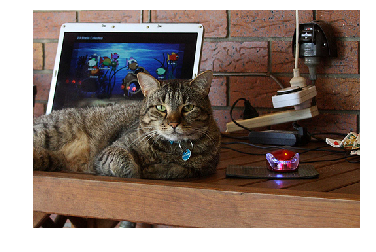

a               7.1889872550964355
cat             5.60890531539917
that            15.80295467376709
is              22.855667114257812
laying          70.65830993652344
next            114.22158813476562
to              77.71632385253906
a               27.8737850189209
computer        14.54294204711914
mouse           -9.178448677062988
<END>           104.50477600097656
- - - -
Avg reward:  45.1769


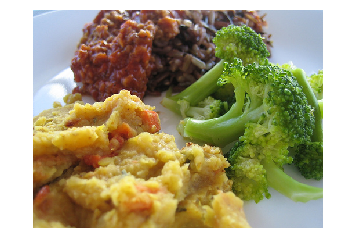

a               -37.41987991333008
plate           45.92534255981445
of              64.4736328125
food            96.9508285522461
is              106.75445556640625
seen            69.78679656982422
in              13.430387496948242
this            -3.774008274078369
picture         5.852844715118408
<END>           89.78900146484375
- - - -
Avg reward:  34.6364


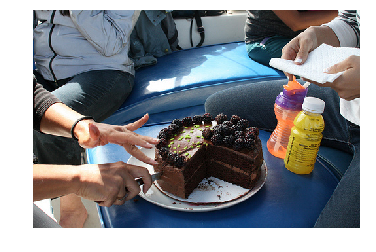

this            -13.436151504516602
is              -6.50875997543335
a               -6.206600666046143
group           -26.767314910888672
of              9.424864768981934
people          -21.623998641967773
cutting         39.792476654052734
up              94.42143249511719
a               120.7789535522461
<UNK>           103.57467651367188
chocolate       29.114072799682617
cake            4.163308620452881
<END>           123.54670715332031
- - - -


SAMPLED RESULTS
[1109 1885 1022 1699]
Avg reward:  30.137


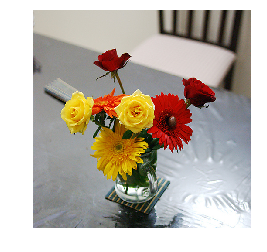

a               -4.7773542404174805
table           2.3214046955108643
topped          45.85407638549805
with            70.67852020263672
a               106.61656188964844
silver          86.10099029541016
tray            -22.140424728393555
and             75.69330596923828
two             -19.21843147277832
candles         6.080659866333008
on              28.63164710998535
top             -20.386281967163086
of              -6.049254894256592
it              19.705686569213867
<END>           82.94444274902344
- - - -
Avg reward:  -33.7203


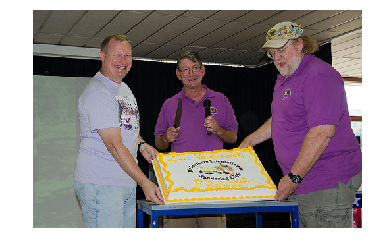

people          -9.17702865600586
on              -29.86115837097168
boats           -65.83599853515625
riding          -117.47782135009766
along           -44.551509857177734
a               -28.628755569458008
river           -87.49111938476562
with            72.34385681152344
flowers         -35.16264343261719
on              -3.3404061794281006
the             6.3532395362854
<UNK>           -1.4480695724487305
<END>           -94.08705139160156
- - - -
Avg reward:  -36.6079


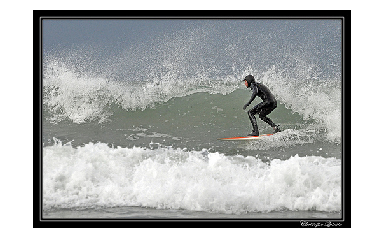

a               20.643360137939453
birthday        0.6086898446083069
cake            -33.661617279052734
with            -68.61437225341797
white           -92.42256164550781
<UNK>           -106.83245849609375
and             -38.692562103271484
some            -13.264723777770996
flowers         -5.436203956604004
on              -14.201205253601074
it              9.226080894470215
<END>           -96.64691162109375
- - - -
Avg reward:  34.7459


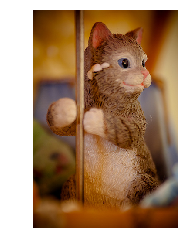

the             -6.737513065338135
display         -3.491117000579834
counter         41.55634307861328
of              62.43191146850586
items           107.69812774658203
<UNK>           97.46258544921875
for             49.092411041259766
sale            -7.31494665145874
at              38.00162124633789
a               -27.35184097290039
pizza           -43.11685562133789
shop            56.19804000854492
<END>           87.26806640625
- - - -


In [26]:
examine_batch_results(train_data, demo_or_sampled_batch, image_idx_batch, caption_batch, m, me)

Avg reward:  41.299


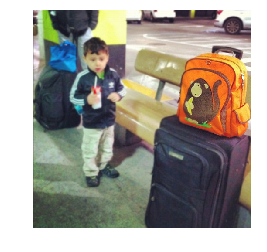

a               -0.1253015697002411
child           -18.8502197265625
standing        -25.89856719970703
near            -42.55715560913086
a               3.912740468978882
pile            23.35085678100586
of              40.057884216308594
luggage         71.39665222167969
bags            159.81077575683594
<END>           201.89224243164062
- - - -
Avg reward:  -17.6447


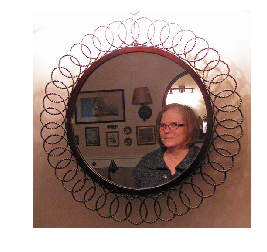

a               7.9144110679626465
photo           1.793107271194458
of              -3.7050044536590576
a               15.083463668823242
woman           -1.1485929489135742
looking         -15.841201782226562
into            -16.39840316772461
a               -21.15660858154297
mirror          -4.843905925750732
<END>           -138.14456176757812
- - - -
Avg reward:  49.6356


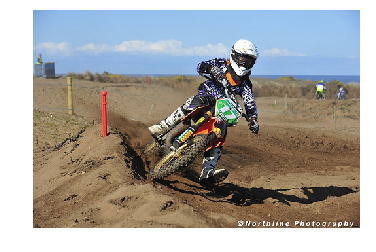

a               15.324219703674316
<UNK>           4.617514133453369
<UNK>           -1.7186131477355957
riding          23.425823211669922
in              78.61105346679688
a               38.803306579589844
dirt            171.8070068359375
field           47.30693054199219
<END>           68.54359436035156
- - - -
Avg reward:  41.008


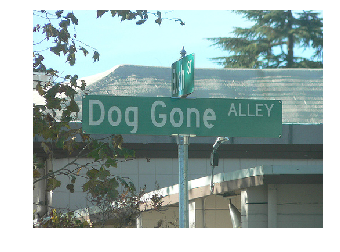

the             48.950801849365234
street          19.12623405456543
sign            21.18931770324707
shows           12.803449630737305
the             54.188499450683594
<UNK>           29.672361373901367
of              76.03694152832031
two             45.43389892578125
<UNK>           38.53038024902344
<UNK>           8.03722858428955
<END>           97.11939239501953
- - - -
Avg reward:  37.6612


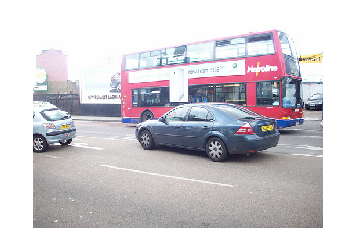

two             37.537837982177734
cars            8.085599899291992
and             1.4649447202682495
a               5.703650951385498
bus             65.20072174072266
on              104.31182098388672
a               61.12803268432617
road            119.15118408203125
next            -72.20780944824219
to              45.683536529541016
<UNK>           -24.396251678466797
<END>           100.27163696289062
- - - -
Avg reward:  -36.6547


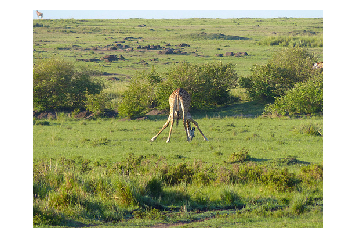

an              61.70532989501953
empty           -2.5320191383361816
bathroom        -33.48065185546875
with            -55.769466400146484
a               -91.28228759765625
small           -105.60784912109375
sink            -75.65814208984375
and             -25.933242797851562
two             -8.149080276489258
towel           -23.56731605529785
<UNK>           26.119693756103516
<END>           -105.70133209228516
- - - -
Avg reward:  -31.4174


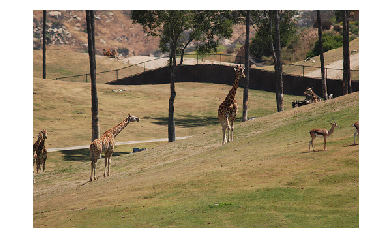

a               43.31150817871094
<UNK>           1.272339105606079
dog             -0.30524298548698425
sticking        -38.76449966430664
his             -40.7392578125
head            -78.00755310058594
out             -127.18922424316406
the             -63.645286560058594
window          -30.956830978393555
of              11.287656784057617
a               -24.302120208740234
moving          -20.595788955688477
car             13.492788314819336
<END>           -84.70208740234375
- - - -
Avg reward:  -47.5927


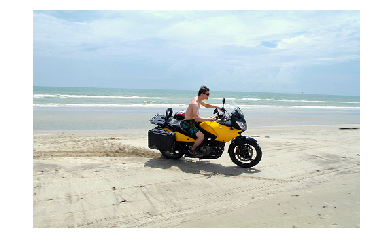

a               13.757627487182617
mirror          -6.084866046905518
showing         -20.657209396362305
a               -21.591251373291016
lady            -50.64296340942383
looking         -39.355010986328125
at              -102.22276306152344
<UNK>           -42.26822280883789
<END>           -159.26988220214844
- - - -
Avg reward:  -7.10814


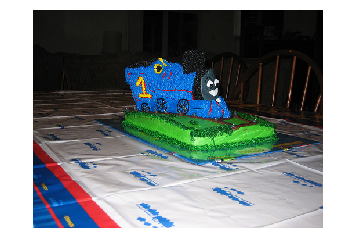

<UNK>           12.304308891296387
<UNK>           -3.5142033100128174
<UNK>           0.8160385489463806
<UNK>           5.880098819732666
to              6.170290946960449
a               7.378463268280029
man             -2.424492120742798
on              -19.82223892211914
the             -11.693086624145508
street          -5.936295986175537
<END>           -67.34838104248047
- - - -
Avg reward:  -36.6553


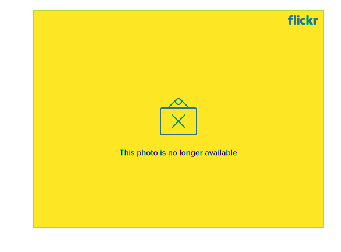

a               51.30168533325195
bathroom        -12.856012344360352
with            -32.774593353271484
a               -47.92011642456055
sink            -104.74971771240234
and             -117.72500610351562
a               -52.5782356262207
air             -62.76608657836914
<UNK>           63.390541076660156
in              -44.52997970581055
it              19.74849510192871
<END>           -98.40496826171875
- - - -


-31.138748

In [27]:
examine_validation(5, to_examine=True)


#### Bidirectional with tanh doesn't do well, it seems to assign all the tokens in that category (all 1 or all neg 1) after 600 iter / 2000 bath size
#### Bidirectional without tanh seems to do qualitatively better - needs a metric that can compare across different methods
#### Uni-directional with difference of hidden states make results more discriminative at word levels
#### Bidirectional with difference of hidden states are also more disciminative

#### Removing first start token makes good difference. To redo experiments. Initial results after 100 iter/ 1000 batch size per each demo/sample

In [63]:

# imgcaptions_idx = [11,12,40]
# captions = [random_sentence()[0] for _ in range(len(img_idx))]
# _ = assign_reward(sess, discr, val_data, img_idx, captions)

Avg reward:  -39.9923
URL Error:  [Errno 8] nodename nor servname provided, or not known http://farm9.staticflickr.com/8087/8387551525_34e4e51cc3_z.jpg


TypeError: Image data can not convert to float